<a href="https://colab.research.google.com/github/adhang/data-science-digitalskola/blob/update/09.%20Database%20Programming/Homework%20-%20Database%20Programming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Homework - Database Programming
Author: Adhang Muntaha Muhammad

[![LinkedIn](https://img.shields.io/badge/linkedin-0077B5?style=for-the-badge&logo=linkedin&logoColor=white&link=https://www.linkedin.com/in/adhangmuntaha/)](https://www.linkedin.com/in/adhangmuntaha/)
[![GitHub](https://img.shields.io/badge/github-121011?style=for-the-badge&logo=github&logoColor=white&link=https://github.com/adhang)](https://github.com/adhang)
[![Kaggle](https://img.shields.io/badge/kaggle-20BEFF?style=for-the-badge&logo=kaggle&logoColor=white&link=https://www.kaggle.com/adhang)](https://www.kaggle.com/adhang)
[![Tableau](https://img.shields.io/badge/tableau-E97627?style=for-the-badge&logo=tableau&logoColor=white&link=https://public.tableau.com/app/profile/adhang)](https://public.tableau.com/app/profile/adhang)
___

## Problems and Tasks
**Datasets**
1. `cb_stations` table (available on database)
2. `cb_trips` table (available on database)

**Tasks**
1. Join the `cb_stations` and `cb_trips` table based on `cb_stations.station_id` and `cb_trips.end_station_id`
2. Get only the `name`, `region_id`, `rental_methods`, and `tripduration` columns
3. Filter the data where the `tripduration` column contains value more than 1 day (note: the `tripduration` column stores the trip durations in seconds)
4. Create a pivot table to see the station name (`name`) and the average of trip duration (`tripduration`)

## Solutions

### Importing Libraries

In [ ]:
import psycopg2 as pg
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()

/usr/local/lib/python3.7/dist-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


### Creating Connection
**Note:** I will censor my database credential.

In [ ]:
db_con = pg.connect(
    host = 'database_host',
    database = 'database_name',
    user = 'username',
    password = 'password'
)

### Creating Temporary Memory
Cursor is used to store the database table in Python (temporary memory).

In [ ]:
db_cur = db_con.cursor()

### Reading Datasets

Let's check the `cb_stations` table. I use `limit 5` because I just want to check the table.

In [ ]:
sql = """
      select *
      from batch_11.cb_stations
      limit 5
      """
data = pd.read_sql_query(sql, db_con)
data.head()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported
0,128,MacDougal St & Prince St,5687.04,40.727104,-74.002970,71,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,False,1970-01-01
1,224,Spruce St & Nassau St,5137.10,40.711464,-74.005520,71,"CREDITCARD,KEY",0,False,0,0,0,0,True,True,True,False,1970-01-01
2,229,Great Jones St,5636.11,40.727436,-73.993790,71,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,False,1970-01-01
3,410,Suffolk St & Stanton St,5445.02,40.720665,-73.985176,71,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,False,1970-01-01
4,434,9 Ave & W 18 St,6190.08,40.743176,-74.003660,71,"CREDITCARD,KEY",0,False,0,0,0,0,False,False,False,False,1970-01-01


From this table, we can get the `name`, `region_id`, and `rental_methods` column. How about the `cb_trips` table?

In [ ]:
sql = """
      select *
      from batch_11.cb_trips
      limit 5
      """
data = pd.read_sql_query(sql, db_con)
data.head()

,tripduration,starttime,stoptime,start station id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,2183,2013-07-11 20:05:57,2013-07-11 20:42:20,492,W 33 St & 7 Ave,40.750200,-73.990931,265,Stanton St & Chrystie St,40.722293,-73.991475,18638,Subscriber,1968,2
1,315,2013-07-11 20:05:58,2013-07-11 20:11:13,300,Shevchenko Pl & E 6 St,40.728145,-73.990214,526,E 33 St & 5 Ave,40.747659,-73.984907,18236,Subscriber,1969,1
2,1646,2013-07-11 20:06:01,2013-07-11 20:33:27,336,Sullivan St & Washington Sq,40.730477,-73.999061,216,Columbia Heights & Cranberry St,40.700379,-73.995481,15420,Subscriber,1974,1
3,1519,2013-07-11 20:06:01,2013-07-11 20:31:20,427,State St,40.702515,-74.014270,304,Broadway & Battery Pl,40.704633,-74.013617,19034,Customer,N,0
4,9806,2013-07-11 20:06:05,2013-07-11 22:49:31,430,York St & Jay St,40.701485,-73.986569,280,E 10 St & 5 Ave,40.733320,-73.995101,19193,Subscriber,1950,1


From this table, we can get the `tripduration` column. ~~But, the `start station id` column has space. So, it's a bit different from the task description.~~

~~When we try to select a column that has a space (and write the column name as it is), it will raise an error. To solve this problem, we can select that column using double quote `"start station id"`.~~

Edit: my mentor revised the tasks and said that the table's join will be on `cb_stations.station_id` and `cb_trips.end_station_id`.

### Joining Datasets
We will do an inner join on these tables using `cb_stations.station_id` and `cb_trips.end_station_id`.

In [ ]:
sql = """
      select *
      from batch_11.cb_stations cs
      join batch_11.cb_trips ct
      on cs.station_id = ct.end_station_id
      limit 5
      """
data = pd.read_sql_query(sql, db_con)
data.head()

,station_id,name,short_name,latitude,longitude,region_id,rental_methods,capacity,eightd_has_key_dispenser,num_bikes_available,num_bikes_disabled,num_docks_available,num_docks_disabled,is_installed,is_renting,is_returning,eightd_has_available_keys,last_reported,tripduration,starttime,stoptime,start station id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bikeid,usertype,birth_year,gender
0,265,Stanton St & Chrystie St,5523.02,40.722294,-73.99148,71,"CREDITCARD,KEY",35,False,34,1,0,0,True,True,True,False,2021-11-09,2183,2013-07-11 20:05:57,2013-07-11 20:42:20,492,W 33 St & 7 Ave,40.750200,-73.990931,265,Stanton St & Chrystie St,40.722293,-73.991475,18638,Subscriber,1968,2
1,526,E 33 St & 5 Ave,6322.01,40.747658,-73.98491,71,"CREDITCARD,KEY",40,False,1,2,37,0,True,True,True,False,2021-11-09,315,2013-07-11 20:05:58,2013-07-11 20:11:13,300,Shevchenko Pl & E 6 St,40.728145,-73.990214,526,E 33 St & 5 Ave,40.747659,-73.984907,18236,Subscriber,1969,1
2,216,Columbia Heights & Cranberry St,4829.01,40.700380,-73.99548,71,"CREDITCARD,KEY",37,False,26,2,9,0,True,True,True,False,2021-11-09,1646,2013-07-11 20:06:01,2013-07-11 20:33:27,336,Sullivan St & Washington Sq,40.730477,-73.999061,216,Columbia Heights & Cranberry St,40.700379,-73.995481,15420,Subscriber,1974,1
3,304,Broadway & Battery Pl,4962.01,40.704630,-74.01362,71,"CREDITCARD,KEY",34,False,23,4,7,0,True,True,True,False,2021-11-09,1519,2013-07-11 20:06:01,2013-07-11 20:31:20,427,State St,40.702515,-74.014270,304,Broadway & Battery Pl,40.704633,-74.013617,19034,Customer,N,0
4,428,E 3 St & 1 Ave,5553.03,40.724678,-73.98783,71,"CREDITCARD,KEY",41,False,25,3,13,0,True,True,True,False,2021-11-09,1848,2013-07-11 20:06:08,2013-07-11 20:36:56,375,Mercer St & Bleecker St,40.726795,-73.996951,428,E 3 St & 1 Ave,40.724677,-73.987834,15470,Subscriber,1986,1


As you can see, on each row of the result contains the same `station_id` and `end_station_id`. It means, we already joined our tables.

### Filtering Dataset
For this task, we only need the `name`, `region_id`, `rental_methods`, and `tripduration` columns.

In [ ]:
sql = """
      select
        cs.name station_name,
        cs.region_id,
        cs.rental_methods,
        ct.tripduration
      from batch_11.cb_stations cs
      join batch_11.cb_trips ct
      on cs.station_id = ct.end_station_id
      limit 5
      """
data = pd.read_sql_query(sql, db_con)
data.head()

,station_name,region_id,rental_methods,tripduration
0,Stanton St & Chrystie St,71,"CREDITCARD,KEY",2183
1,E 33 St & 5 Ave,71,"CREDITCARD,KEY",315
2,Columbia Heights & Cranberry St,71,"CREDITCARD,KEY",1646
3,Broadway & Battery Pl,71,"CREDITCARD,KEY",1519
4,E 3 St & 1 Ave,71,"CREDITCARD,KEY",1848


Beside that, we have to filter the data where the `tripduartion` is larger than 1 day.

Since the `tripduration` column stores the trip durations in seconds, we need to calculate how many seconds in a single day.

In [ ]:
# 24 hours * 60 minutes * 60 seconds
print(24 * 60 * 60)

86400


Now we know the threshold for filtering the `tripduration` column. Let's filter it.

In [ ]:
sql = """
      select
        cs.name station_name,
        cs.region_id,
        cs.rental_methods,
        ct.tripduration
      from batch_11.cb_stations cs
      join batch_11.cb_trips ct
      on cs.station_id = ct.end_station_id
      where tripduration > 86400
      """
data = pd.read_sql_query(sql, db_con)
data.head()

,station_name,region_id,rental_methods,tripduration
0,Broadway & W 58 St,71,"CREDITCARD,KEY",167992
1,12 Ave & W 40 St,71,"CREDITCARD,KEY",97014
2,Bedford Ave & S 9 St,71,"CREDITCARD,KEY",87513
3,9 Ave & W 45 St,71,"CREDITCARD,KEY",350865
4,W 17 St & 8 Ave,71,"CREDITCARD,KEY",88057


### Pivot Table
I will create a pivot table to see the station name (`name`) and the average of trip duration (`tripduration`).

In [ ]:
df_pivot = pd.pivot_table(data, values='tripduration', index=['rental_methods','station_name'], columns='region_id', aggfunc='mean')
df_pivot

region_id                                           71
rental_methods station_name                           
CREDITCARD,KEY 12 Ave & W 40 St                97014.0
               8 Ave & W 33 St                217948.0
               9 Ave & W 45 St                350865.0
               Atlantic Ave & Furman St       120336.0
               Bedford Ave & S 9 St            99181.0
               Broadway & W 56 St              88411.0
               Broadway & W 58 St             167992.0
               Columbia St & Rivington St     145506.0
               E 3 St & 1 Ave                 100848.0
               FDR Drive & E 35 St           6250750.0
               Forsyth St & Canal St           93452.0
               Franklin Ave & Myrtle Ave      409415.0
               Fulton St & Clermont Ave       159004.0
               Hancock St & Bedford Ave       102653.5
               Kent Ave & S 11 St             118257.0
               Lafayette St & E 8 St          124456.0
               Lawrence St & Willoughby St    113089.0
               Leonard St & Church St          90965.0
               Old Fulton St                  730955.0
               S 5 Pl & S 5 St                109207.0
               W 17 St & 8 Ave                 88057.0
               W 42 St & 8 Ave                332510.0
               W 44 St & 5 Ave                104368.0
               Willoughby Ave & Walworth St   601177.0

### Visualize Top 5
It's not listed as one of the tasks, but I just want to do it for learning purpose.

In [ ]:
df_pivot = pd.pivot_table(data, values='tripduration', index=['rental_methods','station_name'], columns='region_id', aggfunc='mean')
df_pivot.head()

region_id                                      71
rental_methods station_name                      
CREDITCARD,KEY 12 Ave & W 40 St           97014.0
               8 Ave & W 33 St           217948.0
               9 Ave & W 45 St           350865.0
               Atlantic Ave & Furman St  120336.0
               Bedford Ave & S 9 St       99181.0

Let's remove the dataframe column name (`region_id`).

In [ ]:
df_pivot.columns.name

'region_id'

In [ ]:
df_pivot.columns.name = None
df_pivot.head()

71
rental_methods station_name                      
CREDITCARD,KEY 12 Ave & W 40 St           97014.0
               8 Ave & W 33 St           217948.0
               9 Ave & W 45 St           350865.0
               Atlantic Ave & Furman St  120336.0
               Bedford Ave & S 9 St       99181.0

Since it only contains 1 rental method, I will reset the index and drop the `rental_methods`.

In [ ]:
df_pivot = df_pivot.reset_index().drop('rental_methods', axis=1)
df_pivot.head()

,station_name,71
0,12 Ave & W 40 St,97014.0
1,8 Ave & W 33 St,217948.0
2,9 Ave & W 45 St,350865.0
3,Atlantic Ave & Furman St,120336.0
4,Bedford Ave & S 9 St,99181.0


The table only contains 1 region (71), let's change the column name to make it easier to interpret.

In [ ]:
df_pivot.rename(columns={71: 'avg_duration'}, inplace=True)
df_pivot.head()

,station_name,avg_duration
0,12 Ave & W 40 St,97014.0
1,8 Ave & W 33 St,217948.0
2,9 Ave & W 45 St,350865.0
3,Atlantic Ave & Furman St,120336.0
4,Bedford Ave & S 9 St,99181.0


Finally, order the dataframe based on `avg_duration`.

In [ ]:
df_pivot.sort_values(by='avg_duration', inplace=True)
df_pivot.head()

,station_name,avg_duration
20,W 17 St & 8 Ave,88057.0
5,Broadway & W 56 St,88411.0
17,Leonard St & Church St,90965.0
10,Forsyth St & Canal St,93452.0
0,12 Ave & W 40 St,97014.0


Finally, visualize the top 5. Since the dataframe is in ascending order, we will use 'tail(5)' to get the last 5 rows (which is the highest value).

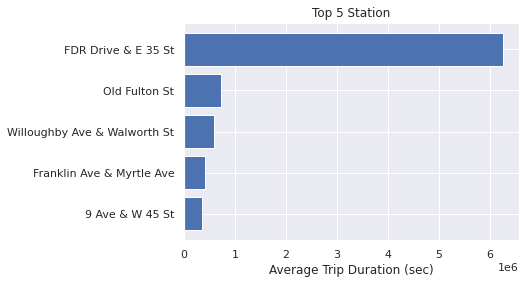

In [ ]:
top_5 = df_pivot.tail(5)

plt.barh(y=top_5['station_name'], width=top_5['avg_duration'])
plt.xlabel('Average Trip Duration (sec)')
plt.title('Top 5 Station')
plt.show()

From this plot, we can't exactly answer "how long is it?". That's because the average trip duration is in seconds. To make it easier to understand, let's convert it to hours.

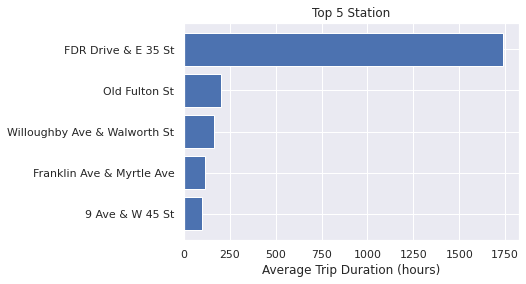

In [ ]:
plt.barh(y=top_5['station_name'], width=top_5['avg_duration']/(60*60))
plt.xlabel('Average Trip Duration (hours)')
plt.title('Top 5 Station')
plt.show()

Since the trip duration is still high, let's try to convert it to days.

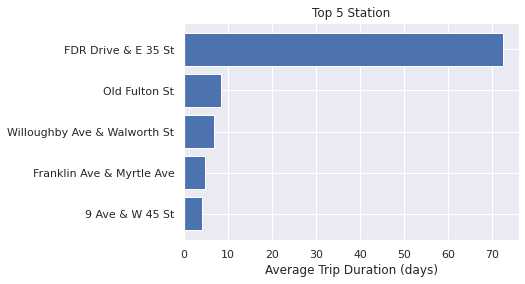

In [ ]:
plt.barh(y=top_5['station_name'], width=top_5['avg_duration']/(24*60*60))
plt.xlabel('Average Trip Duration (days)')
plt.title('Top 5 Station')
plt.show()

I think it's better.

As we can see, `FDR Drive & E 35 St` has the highest average trip duration. When compared to the other stations, the difference gaps are very high.